In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastai import *
#from torch.utils import data
from fastai.vision import *
import warnings
from torch.utils.data import SequentialSampler
from fastai3D import mysampler
from fastai3D import loader #does not comply 
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [8]:
#path = untar_data(URLs.CAMVID_TINY)#small segmentation test set
#path_img = path/'images' #should later be provided through ini file
#path_lbl = path/'labels' #should later be provided through ini file
#path.ls()
#parts = np.loadtxt(path/'codes.txt', dtype=str); parts #should later be provided through ini file
#these setting should later be set through an ini file
#bs = 4 #batch size, set smaller when running out of memory
#get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [9]:
#Data Block API
#data = SegmentationItemList.from_folder(path_img).split_by_rand_pct(valid_pct=0.2, seed=42) #for seed validation use an unseen kernel? because slices are not independent of eachother (like video)
#data = data.label_from_func(get_y_fn, classes=parts)
#data = data.transform(get_transforms(), tfm_y=True, size=128) #for the seeds set get_transforms(flip_vert:bool=True) and perhaps something with max_rotate()
#data = data.databunch(bs=bs, path=path)
#data = data.normalize() #think about this for the seeds
#data

In [10]:
#Have a quick look at the data (optional)
#data.show_batch(rows=2, figsize=(7,5))
#learn = unet_learner(data, models.resnet18) #think of other arguments to pass, such as custom defined metrics
#learn.fit_one_cycle(cyc_len=10, max_lr=1e-2) #what other argumenets should be passed in? how many epochs? what lr
#learn.show_results()

##Seed Data

In [11]:
path = Path('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train')
path_img = path/'Images' #should later be provided through ini file
path_lbl = path/'Labels' #should later be provided through ini file
classes = range(4)

def get_mask(img):
    return (path_lbl)/img.name

In [12]:
"""function to filter out images that only contain background; used to filter in the data block API; 
function has to return a boolean
slow, every mask has to be opened to check the values"""
def check_back(img):
    mask = open_mask(get_mask(img))
    count_total=(torch.unique(mask.data, return_counts=True))
    if not count_total[0].tolist() == [0]:
        return True
    else:
        return False

In [13]:
data = SegmentationItemList.from_folder(path).filter_by_func(check_back).split_by_fname_file('valid.txt')

In [14]:
data = data.label_from_func(get_mask, classes=classes)

In [15]:
data = data.transform(get_transforms(flip_vert=True), tfm_y=True, size=128)

In [16]:
data = data.databunch(bs=1)

In [17]:
data = data.normalize()

In [18]:
data.train_dl = data.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data.train_dl), 2, True))

In [19]:
data.batch_size

2

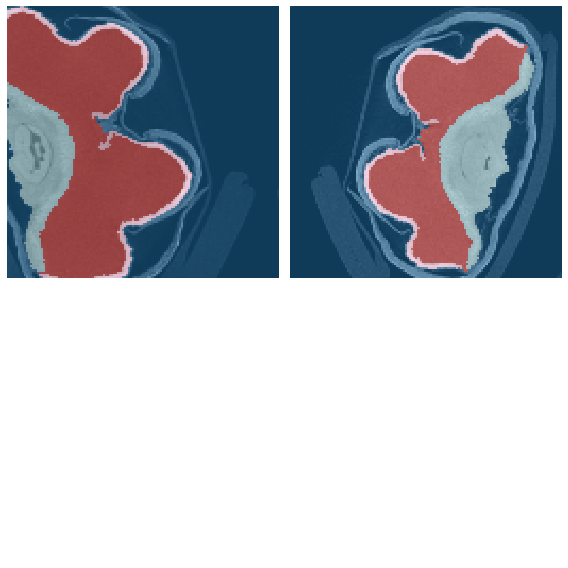

In [20]:
data.show_batch(4)

Seed data to Learner

In [21]:
def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [28]:
metrics=acc_seeds
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
__________________________________________________

In [23]:
#learn.lr_find()
#learn.recorder.plot()

In [43]:
a_batch = data.one_batch(detach=True)
a_batch
a_batch[1].size()

torch.Size([2, 1, 128, 128])

In [56]:
img1 = torch.Tensor(a_batch[0][0])
img2 = torch.Tensor(a_batch[0][1])
img1.size()

torch.Size([3, 128, 128])

In [73]:
two_img = img1
two_img = torch.stack((img1, img2), dim = 3)
two_img.size()


torch.Size([3, 128, 128, 2])

In [64]:
from torch import nn

In [81]:
simple_3conv = nn.Conv3d(in_channels=3, out_channels=128, kernel_size=(128,2), stride=1, padding=(0, 1, 1))
#input = torch.randn(1,3 , 6, 10, 10)
#print(input)
#output = simple_3conv(input)
#output.size()
#torch.Size([1, 30, 3, 10, 10])
simple_2conv = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=2, stride =1, padding=(0,1))

In [82]:
output = simple_2conv(img1)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 128 3 2 2, but got 3-dimensional input of size [3, 128, 128] instead